In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from transformers import TFAutoModel, AutoTokenizer

c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load datasets

In [2]:
train_df = pd.read_csv('Train.csv')
train_df.head()

NameError: name 'pd' is not defined

In [10]:
test_df = pd.read_csv('Test.csv')
test_df.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


## Data Preprocessing

In [11]:
# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Text processing function
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

# Apply preprocessing to the datasets
train_df["clean_text"] = train_df["text"].apply(preprocess_text)
test_df["clean_text"] = test_df["text"].apply(preprocess_text)

# Tokenization
max_words = 1000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test = tokenizer.texts_to_sequences(test_df["clean_text"])

# Padding the sequences
max_len = 35  # Maximum sequence length
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding="post" )
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding="post")

# Display processed data samples
train_df[["text", "clean_text"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Esther\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,I feel that it was better I dieAm happy,feel better dieam happy
1,Why do I get hallucinations?,get hallucinations
2,I am stresseed due to lack of financial suppor...,stresseed due lack financial support school
3,Why is life important?,life important
4,How could I be helped to go through the depres...,could helped go depression


In [1]:
# Maximum length of a sentence
max_length = max(train_df['text'].apply(lambda x: len(x.split())))
print(f"Maximum Length (number of words in the clean text): {max_length}")


NameError: name 'train_df' is not defined

In [6]:
# After tokenizing count unique words
all_words = [word for text in train_df['text'] for word in text.split()]
unique_words = set(all_words)
print(f"Number of Unique Words: {len(unique_words)}")


Number of Unique Words: 1030


In [12]:
X_train_raw = train_df["text"] 
X_test_raw = test_df["text"]  

# TF-IDF Encoding
vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw).toarray()
X_test_tfidf = vectorizer.transform(X_test_raw).toarray()

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["label"])

# One-hot encode labels for categorical classification
y_train = to_categorical(train_labels_encoded)

# Display label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping


{'Alcohol': np.int64(0),
 'Depression': np.int64(1),
 'Drugs': np.int64(2),
 'Suicide': np.int64(3)}

## Modelling.
### LSTM

In [ ]:
# Define model parameters
embedding_dim = 128  # Size of word embeddings
lstm_units = 128  # Number of LSTM units
num_classes = len(label_mapping)  # For multi-class classification (e.g., Depression, Suicide, Alcohol, Drugs)
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

# Define class weights for imbalance handling
total_samples = len(y_train)
class_weights = {i: total_samples / (num_classes * sum(y_train[:, i])) for i in range(num_classes)}

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Build the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),  # based on vocab size and max_len
    Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(lstm_units, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)
model.build(input_shape=(None, max_len))

model.summary()


c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 35, 128)        │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 35, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 35, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 35, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,164 (3.07 MB)

 Trainable params: 803,140 (3.06 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [18]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    epochs=15,  # Maximum epochs
    batch_size=32,  # Batch size
    validation_split=0.2,  # 20% of data for validation
    class_weight=class_weights,  # Handling class imbalance
    callbacks=[early_stopping]  # Include early stopping
)

# Save the model
#model.save("lstm_mental_health_model.keras")

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.9783 - loss: 1.3769 - val_accuracy: 0.3387 - val_loss: 2.5482
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.9650 - loss: 1.3197 - val_accuracy: 0.3871 - val_loss: 2.4693
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9636 - loss: 1.2929 - val_accuracy: 0.2984 - val_loss: 3.0068
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.9552 - loss: 1.2189 - val_accuracy: 0.4435 - val_loss: 2.1767
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9510 - loss: 1.1104 - val_accuracy: 0.6210 - val_loss: 1.9098
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.9758 - loss: 1.0491 - val_accuracy: 0.3629 - val_loss: 2.4523
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.9616 - loss: 1.0252 - val_accuracy: 0.4113 - val_loss: 2.2817
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.9764 - loss: 0.8925 - val_accuracy: 0.

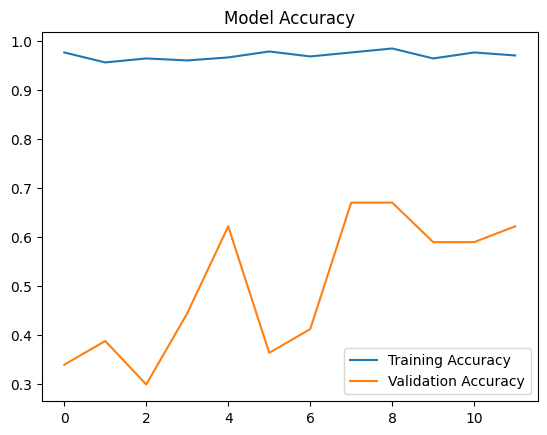

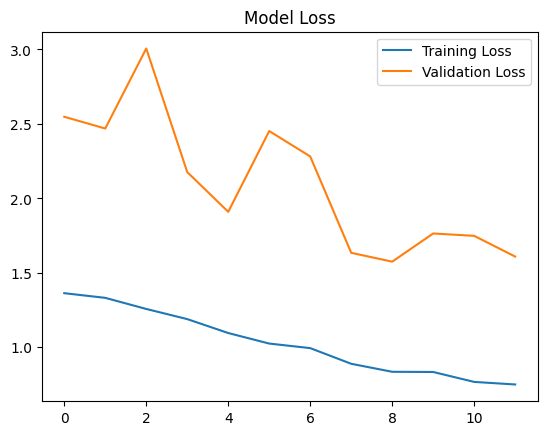

In [20]:
# visualize the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

### 2. GRU

In [ ]:
# Define model parameters
embedding_dim = 128  # Size of word embeddings
gru_units = 128  # GRU units
num_classes = len(label_mapping)  # 4 classes (Depression, Suicide, Alcohol, Drugs)
learning_rate = 0.005  # Lower learning rate

# Build the improved GRU model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(GRU(gru_units, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(GRU(gru_units, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Multi-class classification
])

model.build(input_shape=(None, max_len))  # Set batch size as None (dynamic)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 35, 128)        │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 35, 256)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 35, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 35, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,348 (2.45 MB)

 Trainable params: 640,324 (2.44 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [21]:
# Compile the model with improved optimizer
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) k

# Train the model with class weighting and learning rate scheduler
total_samples = len(y_train)
class_weights = {i: total_samples / (num_classes * sum(y_train[:, i])) for i in range(num_classes)}

lr_schedule = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

history = model.fit(
    X_train_tfidf, y_train,
    epochs=15, batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[lr_schedule]
)

# Save the improved model
#model.save("gru_mental_health_model.keras")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 35, 128)        │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 35, 256)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 35, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 35, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,348 (2.45 MB)

 Trainable params: 640,324 (2.44 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 145s 8s/step - accuracy: 0.4059 - loss: 9.5009 - val_accuracy: 0.2258 - val_loss: 4.9539 - learning_rate: 0.0050
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.2530 - loss: 5.4617 - val_accuracy: 0.5161 - val_loss: 4.4003 - learning_rate: 0.0050
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - accuracy: 0.2555 - loss: 4.8484 - val_accuracy: 0.1452 - val_loss: 4.1942 - learning_rate: 0.0050
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 121s 8s/step - accuracy: 0.2797 - loss: 4.0815 - val_accuracy: 0.1129 - val_loss: 3.8648 - learning_rate: 0.0050
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.2335 - loss: 3.7512 - val_accuracy: 0.1452 - val_loss: 3.6063 - learning_rate: 0.0050
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - accuracy: 0.2365 - loss: 3.5478 - val_accuracy: 0.1452 - val_loss: 3.4100 - learning_rate: 0.0050
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.2872 - loss: 3.3014 - val_acc